True
Mean Percentage Variance: 1.3167275132272718


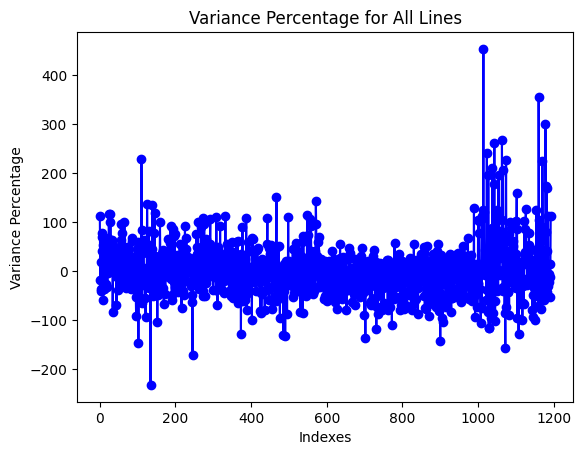

In [12]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import copy
import pickle

cities = ['2800', '2820', '2830', '2840', '2850', '2900', '2920', '2930', '2942', '2950','3000','3460']
energy_classes = ['A2020', 'A2015', 'A2010', 'B', 'C', 'D', 'E', 'F', 'G']
types = ['Villa','Ejerlejlighed','Rækkehus','Villalejlighed']

dataframes = []

for city in cities:
    filename = f'./data/house_data/house_data_{city}.csv'
    df = pd.read_csv(filename)
    df['City'] = city  # Add a 'City' column with the zip code
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)  
scaler = StandardScaler()
combined_df['Size'] = scaler.fit_transform(combined_df[['Size']])

# Fjern rækker med boligtypen "Landejendom"
combined_df = combined_df[combined_df['Type'] != 'Landejendom']

# Fjern rækker med NaN-værdier
combined_df = combined_df.dropna()

# Deepcopy the combined DataFrame
original_df = copy.deepcopy(combined_df)

combined_df = pd.get_dummies(combined_df, columns=['City', 'Energy class', 'Type'])

scaler = StandardScaler()
combined_df['Size'] = scaler.fit_transform(combined_df[['Size']])

with open('linear_model.pkl', 'rb') as file:
    linear_model = pickle.load(file)

predicted_prices = []
df_results = pd.DataFrame(columns=['Predicted Price', 'Original Price', 'Variance'])

for idx, row in combined_df.iterrows():
    linenumber = idx

    original_price = original_df.loc[linenumber, 'Price']

    new_data = {
        'X': combined_df.loc[linenumber, 'X'],
        'Y': combined_df.loc[linenumber, 'Y'],
        'Size': combined_df.loc[linenumber, 'Size'],
        'City_2800': combined_df.loc[linenumber, 'City_2800'],
        'City_2820': combined_df.loc[linenumber, 'City_2820'],
        'City_2830': combined_df.loc[linenumber, 'City_2830'],
        'City_2840': combined_df.loc[linenumber, 'City_2840'],
        'City_2850': combined_df.loc[linenumber, 'City_2850'],
        'City_2900': combined_df.loc[linenumber, 'City_2900'],
        'City_2920': combined_df.loc[linenumber, 'City_2920'],
        'City_2930': combined_df.loc[linenumber, 'City_2930'],
        'City_2942': combined_df.loc[linenumber, 'City_2942'],
        'City_2950': combined_df.loc[linenumber, 'City_2950'],
        'City_3000': combined_df.loc[linenumber, 'City_3000'],
        'City_3460': combined_df.loc[linenumber, 'City_3460'],
        'Energy class_A2010': combined_df.loc[linenumber, 'Energy class_A2020'],
        'Energy class_A2015': combined_df.loc[linenumber, 'Energy class_A2015'],
        'Energy class_A2020': combined_df.loc[linenumber, 'Energy class_A2010'],
        'Energy class_B': combined_df.loc[linenumber, 'Energy class_B'],
        'Energy class_C': combined_df.loc[linenumber, 'Energy class_C'],
        'Energy class_D': combined_df.loc[linenumber, 'Energy class_D'],
        'Energy class_E': combined_df.loc[linenumber, 'Energy class_E'],
        'Energy class_F': combined_df.loc[linenumber, 'Energy class_F'],
        'Energy class_G': combined_df.loc[linenumber, 'Energy class_G'],
        'Type_Ejerlejlighed': combined_df.loc[linenumber, 'Type_Ejerlejlighed'],
        'Type_Rækkehus': combined_df.loc[linenumber, 'Type_Rækkehus'],
        'Type_Villa': combined_df.loc[linenumber, 'Type_Villa'],
        'Type_Villalejlighed': combined_df.loc[linenumber, 'Type_Villalejlighed'],
    }

   # Create a new DataFrame with the new data
   
    new_df = pd.DataFrame([new_data])
    new_df['Size'] = scaler.transform(new_df[['Size']])
    

    # Make the prediction
    prediction = int(linear_model.predict(new_df))

     # Calculate the variance
    variance = original_price - prediction

    variance_percent = (variance / original_price) * 100

    # Create a temporary DataFrame with the current iteration's results
    temp_df = pd.DataFrame({'Predicted Price': [prediction],
                            'Original Price': [original_price],
                            'Variance': [variance],
                            'Variance %': [variance_percent]})
    # Concatenate the temporary DataFrame with the df_results DataFrame
    df_results = pd.concat([df_results, temp_df], ignore_index=True)

    predicted_prices.append(prediction)

mean_variance_percent = df_results['Variance %'].mean()

# Print the mean percentage variance
print("Mean Percentage Variance:", mean_variance_percent)

variance_percent = df_results['Variance %']

# Set a threshold for the variance percentage above/below which rows will be considered as high variance
variance_threshold = 50  # Adjust the threshold as per your requirement

# Create a new DataFrame to store rows with high variance
high_variance_df = df_results[(df_results['Variance %'] >= variance_threshold) | (df_results['Variance %'] <= -variance_threshold)]

# Reset the index of the new DataFrame
high_variance_df = high_variance_df.reset_index(drop=True)

# Save the high variance DataFrame 
high_variance_df

# Create an array of line numbers
line_numbers = range(len(variance_percent))

# Create the line plot
plt.plot(line_numbers, variance_percent, marker='o', linestyle='-', color='blue')

# Set labels and title
plt.xlabel('Indexes')
plt.ylabel('Variance Percentage')
plt.title('Variance Percentage for All Lines')

# Show the plot
plt.show()




'''
Hvis din model forudsiger negative priser for nogle af de boliger, som den blev trænet på, 
kan det indikere, at modellen ikke er passende eller effektiv til formålet med lineær regression. 
Lineær regression antager en lineær sammenhæng mellem funktionerne (features) og målvariablen, 
hvilket muligvis ikke er tilfældet for dit datasæt.

Der kan være flere årsager til, at modellen forudsiger negative priser. Her er nogle mulige faktorer, du kan undersøge:

Manglende relevante funktioner: Modellen kan have brug for yderligere funktioner eller attributter, 
der er mere relevante for at forudsige boligpriserne. 
Du kan undersøge, om der er andre vigtige funktioner, der skal medtages i modellen, 
såsom antallet af værelser, boligens alder, beliggenhed eller andre.

Skaleringsproblemer: Hvis featuresne ikke er korrekt skaleret, kan det påvirke modellens præstation. 
Du bruger en StandardScaler til at normalisere "Size" featuren, men det kan være værd at kontrollere, 
om andre funktioner også har brug for skaleringsbehandling for at sikre, at de har en passende indvirkning på prædiktionerne.

Ikke-lineære relationer: Lineær regression antager en lineær sammenhæng mellem funktionerne og målvariablen. Hvis der er ikke-lineære relationer i dine data, kan det være nødvendigt at eksperimentere med mere avancerede modeller eller ikke-lineære transformationer af dataene.

Datasætkvalitet: Kontroller datasættet for eventuelle fejl eller outliers, der kan påvirke modellens præstation. Udrensning af unøjagtige eller forkerte datapunkter kan hjælpe med at forbedre modellens prædiktioner.

Husk, at lineær regression ikke altid er den bedste model til alle typer af data eller prædiktionsopgaver. Du kan overveje at udforske andre regressionsmodeller eller maskinlæringsmetoder, der bedre passer til dine data og formål.

'''